# Непараметрические гипотезы
---
# Терапия при анорексии

В исследовании оценивается эффективность поведенческой терапии для лечения анорексии. Для 50 пациентов известен вес до начала терапии и по её окончании. Была ли терапия эффективной?

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

from scipy.stats import norm, t

In [2]:
w = pd.read_table("weight.txt")

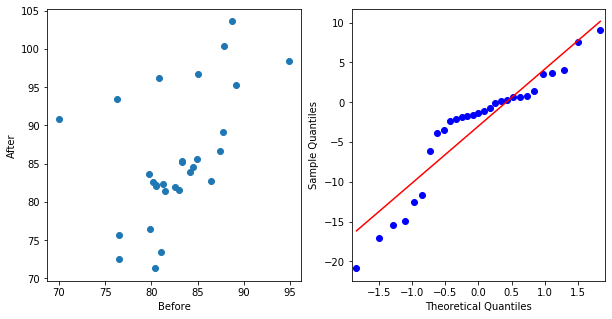

In [3]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
ax1.scatter(w['Before'], w['After'])
ax1.set(xlabel='Before', ylabel='After')
sm.qqplot(w['Before'] - w['After'], line ='s', ax=ax2)
plt.show()

1. Воспользуйтесь критериями знаков (`sign_test` из библиотеки `statsmodels`), критерием Уилкоксона (`wilcoxon` из библиотеки `scipy`). Не забудьте, что мы работаем со связанными выборками!

In [4]:
from statsmodels.stats.descriptivestats import sign_test

sign_test(w["After"], w["Before"])

(3.5, 0.26493089646101)

In [5]:
from scipy.stats import wilcoxon

wilcoxon(w["After"], w["Before"], correction=True)

WilcoxonResult(statistic=131.5, pvalue=0.06446563934437059)

2. C помощью бутстрэпа из 10000 повторений постройте доверительный интервал на медиану разницы веса до и после лечения. (в двух вариантах: с помощью `np.random.choice` и с помощью метода `bootstrap` из библиотеки `bootstrapped`)

In [6]:
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

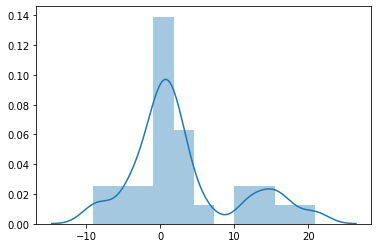

In [7]:
# Distribution of the initial samples
samples = np.array(w["After"] - w["Before"])
sns.distplot(samples)
plt.show()

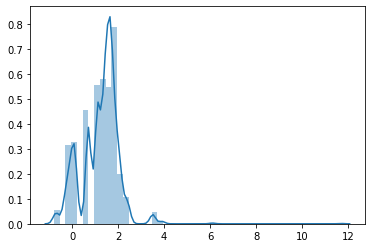

In [8]:
# Distribution of the bootstrapped sample statistics (here, median)
n_tries, n_samples = 10000, samples.shape[0]

median_distr = np.median(np.random.choice(samples, [n_tries, n_samples]), axis=1)
sns.distplot(median_distr)
plt.show()

In [9]:
# As our distribution in general is not normal,
#  we use robust quantile estimation
np.quantile(median_distr, 0.5) # bootsrapped value, same as np.median

1.3999999999999915

In [10]:
# Confident interval is also constructed via quantiles
# (how we looked at the source code of the facebook library)
alpha = 0.05 # significance level
print('Estimated Median: {0:.3f}   Left Bound: {1:.3f}   Right Bound: {2:.3f}'.format(
    np.quantile(median_distr, 0.5), *np.quantile(median_distr, (alpha / 2, 1 - alpha / 2))
))

Estimated Median: 1.400   Left Bound: -0.300   Right Bound: 2.400


In [11]:
# We can also can try to construct parametric approximation,
#  but here we get much more inaccuracy both with Student and Normal

median_mean = np.mean(median_distr)
median_std = np.std(median_distr, ddof=1)

In [12]:
# Normal approximation
left_bound = norm(median_mean, median_std).ppf(alpha / 2)
right_bound = norm(median_mean, median_std).ppf(1 - alpha / 2)

# Statistics mean and confident interval
print('Estimated Median: {0:.3f}   Left Bound: {1:.3f}   Right Bound: {2:.3f}'.format(
    median_mean, left_bound, right_bound
))

Estimated Median: 1.221   Left Bound: -0.365   Right Bound: 2.807


In [13]:
# Student approximation (the same as Student with a lot of pseudo samples)
left_bound = t(median_distr.shape[0], median_mean, median_std).ppf(alpha / 2)
right_bound = t(median_distr.shape[0], median_mean, median_std).ppf(1 - alpha / 2)

# Statistics mean and confident interval
print('Estimated Median: {0:.3f}   Left Bound: {1:.3f}   Right Bound: {2:.3f}'.format(
    median_mean, left_bound, right_bound
))

Estimated Median: 1.221   Left Bound: -0.365   Right Bound: 2.808


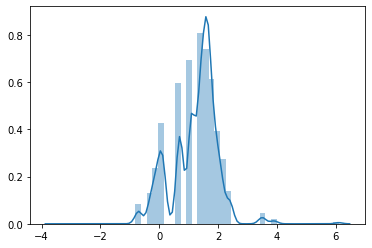

In [14]:
# Than we exploit Facebook bootsrap library for the automatic samples,
#  it works in the same way as we have written before with random.choice
#  and other quantile stuff, thus it is just a cool wrapper

# Two options, the first one with `return_distribution` 
#  is just random.choice (compare the plots)
b_median_distr = bs.bootstrap(samples, stat_func=bs_stats.median,
    return_distribution=True, num_iterations=n_tries)
sns.distplot(b_median_distr)
plt.show()

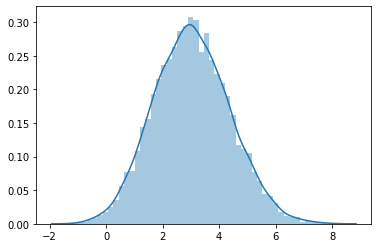

In [15]:
# Just for an interest, how the mean looks like
b_mean_distr = bs.bootstrap(samples, stat_func=bs_stats.mean,
    return_distribution=True, num_iterations=n_tries)
sns.distplot(b_mean_distr)
plt.show()

In [16]:
# Here we calculate central value, left and right confident bounds
print('Estimated Median: {0:.3f}   Left Bound: {1:.3f}   Right Bound: {2:.3f}'.format(
    np.median(b_median_distr),  *np.quantile(b_median_distr, (alpha / 2, 1 - alpha / 2))    
))

Estimated Median: 1.400   Left Bound: -0.300   Right Bound: 2.400


In [17]:
# Additionally (second options), it can be calculated directly,
#  also this library supports batch sampling

# Be carefull with the default `is_pivotal` as it calculates other values,
#  that's it `percentile bootrap`, what we've done before:
bootstrap_results = bs.bootstrap(
    samples, stat_func=bs_stats.median, alpha=0.05, num_iterations=n_tries, is_pivotal=False
)
print('Estimated Median: {0:.3f}   Left Bound: {1:.3f}   Right Bound: {2:.3f}'.format(
    bootstrap_results.value, bootstrap_results.lower_bound, bootstrap_results.upper_bound
))

Estimated Median: 1.400   Left Bound: -0.300   Right Bound: 2.400


In [18]:
# Also see the code and formulas
#  https://github.com/facebookincubator/bootstrapped/blob/bd19cae28728aba0ea74e874fad801794a55a363/bootstrapped/bootstrap.py#L78
#  https://en.wikipedia.org/wiki/Bootstrapping_(statistics) 

---
# Недвижимость в Сиэттле

Имеются данные о продажной стоимости недвижимости в Сиэтле для 50 сделок в 2001 году и 50 в 2002.
Изменились ли цены?

In [19]:
data = pd.read_table("seattle.txt")
x1 = data[data["Year"] == 2001]["Price"].values
x2 = data[data["Year"] == 2002]["Price"].values

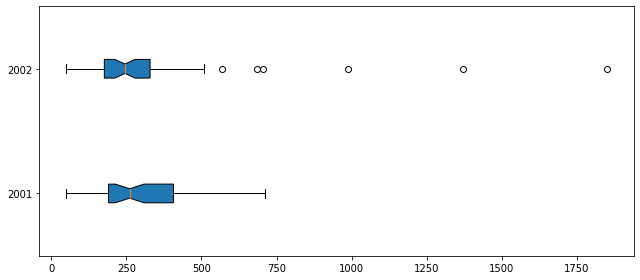

In [20]:
plt.figure(figsize=(9,4))
plt.boxplot([x1, x2], patch_artist=True, notch=True,
                vert=0, labels=['2001', '2002'])
plt.tight_layout()

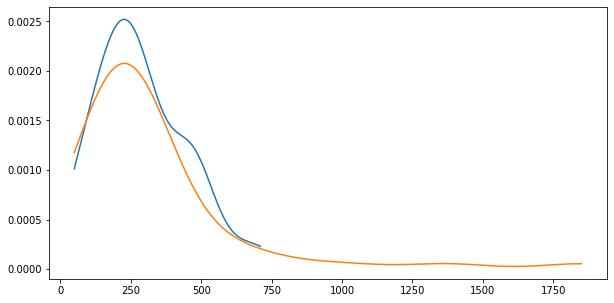

In [21]:
from scipy.stats import gaussian_kde

plt.figure(figsize=(10,5))
density_x1 = gaussian_kde(x1)
density_x2 = gaussian_kde(x2)

x_1 = np.linspace(np.min(x1), np.max(x1), 300)
plt.plot(x_1, density_x1(x_1))

x_2 = np.linspace(np.min(x2), np.max(x2), 300)
plt.plot(x_2, density_x2(x_2))

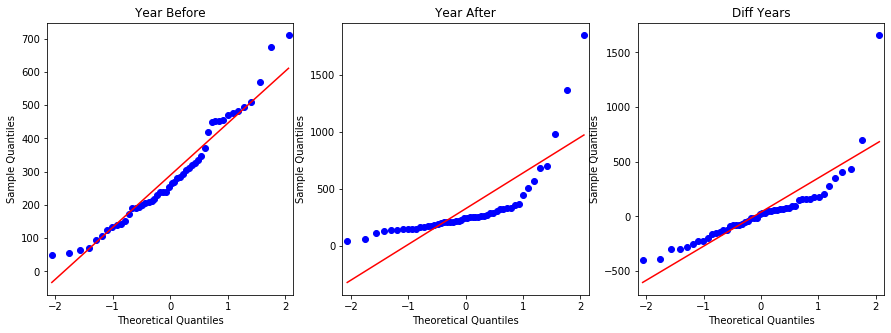

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,5))
sm.qqplot(x1, line ='s', ax=ax1)
sm.qqplot(x2, line ='s', ax=ax2)
sm.qqplot(x2 - x1, line ='s', ax=ax3)

ax1.set_title("Year Before")
ax2.set_title("Year After")
ax3.set_title("Diff Years")
plt.show()

1. Вопсользуйтесь критерием Стьюдента и Манна-Уитни-Уилкоксона (`mannwhitneyu`).

Критерий Манна-Уитни-Уилкоксона:

In [23]:
from scipy.stats import mannwhitneyu
mannwhitneyu(x1, x2)

MannwhitneyuResult(statistic=1204.5, pvalue=0.3781936337850874)

Критерий Стьюдента

In [24]:
from scipy.stats import ttest_ind
ttest_ind(x1, x2)

Ttest_indResult(statistic=-0.8057258725189664, pvalue=0.42235167114691463)

2. Постройте доверительные интервалы для средних значений в обеих выборках, а также доверительный интервал для разницы средних по обеим выборкам.

In [25]:
year_before = bs.bootstrap(x1, bs_stats.mean, is_pivotal=False)
year_after = bs.bootstrap(x2, bs_stats.mean, is_pivotal=False)
year_diff = bs.bootstrap(x2 - x1, bs_stats.mean, is_pivotal=False)

In [26]:
year_before

289.29143    (245.824036, 333.3501905)

In [27]:
year_after

326.70313999999996    (252.85003799999998, 424.7659034999999)

In [28]:
year_diff

36.859210000000004    (-37.723841500000006, 133.93350800000002)

In [29]:
# Let's try using parametric approximation instead of quantilized bootstrap

In [30]:
boot_n = 10000

lst_boot1 = np.mean(np.random.choice(x1, (boot_n, x1.shape[0])), axis=1)
lst_boot2 = np.mean(np.random.choice(x2, (boot_n, x2.shape[0])), axis=1)
lst_boot = lst_boot2 - lst_boot1

SE_bootstrap = np.std(lst_boot, ddof=1)
SE_bootstrap

49.65785414617606

In [31]:
# Year diff approximation
statistic = np.mean(lst_boot)

(statistic, t(boot_n, statistic, SE_bootstrap).ppf(alpha / 2),
    t(boot_n, statistic, SE_bootstrap).ppf(1 - alpha / 2))
# (Central, (Left bound, Right bound))

(40.569234248, -56.77015301964218, 137.90862151564215)

### Изменились ли цены?

Ответ: нет, цены не изменились с уровнем доверия $1 - \alpha = 0.95$, так как ноль (показывает отсутствие изменения) входит в $95\%$ доверительный интервал. Вероятность того, что мы ошиблись, не превышает $5\%$ (ошибка первого рода).